In [22]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

# Set matplotlib to display in notebook
%matplotlib inline
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

ModuleNotFoundError: No module named 'tqdm'

In [13]:
class DemosaicingDataset(Dataset):
    def __init__(self, root_dir, split_file, patch_size=33, stride=33, transform=None):
        """Initialize Demosaicing dataset"""
        self.root_dir = root_dir
        self.groundtruth_dir = os.path.join(root_dir, 'groundtruth')
        self.input_dir = os.path.join(root_dir, 'input')
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform
        
        # Read image list from split file
        with open(split_file, 'r') as f:
            self.image_files = [line.strip() + '.png' for line in f.readlines()]
            
        print(f"Found {len(self.image_files)} images in {os.path.basename(split_file)}")
        
        # Pre-compute patches
        self.patches = self._prepare_patches()
        
    def _prepare_patches(self):
        """Prepare patches from all images"""
        patches = []
        
        for img_file in tqdm(self.image_files, desc="Processing images"):
            # Load ground truth image
            gt_path = os.path.join(self.groundtruth_dir, img_file)
            gt_img = cv2.imread(gt_path)
            gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
            
            # Load input image (raw Bayer)
            input_path = os.path.join(self.input_dir, img_file)
            input_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
            
            # Normalize input to [0, 1]
            input_img = input_img.astype(np.float32) / 65535.0
            gt_img = gt_img.astype(np.float32) / 255.0
            
            # Extract patches
            h, w = input_img.shape
            for i in range(0, h - self.patch_size + 1, self.stride):
                for j in range(0, w - self.patch_size + 1, self.stride):
                    input_patch = input_img[i:i+self.patch_size, j:j+self.patch_size]
                    gt_patch = gt_img[i:i+self.patch_size, j:j+self.patch_size]
                    
                    # Skip patches with low variance
                    if input_patch.std() > 0.02:
                        patches.append({
                            'input': input_patch,
                            'target': gt_patch,
                            'image_file': img_file,
                            'position': (i, j)
                        })
        
        print(f"Extracted {len(patches)} valid patches")
        return patches
    
    def __len__(self):
        return len(self.patches)
    
    def __getitem__(self, idx):
        patch = self.patches[idx]
        
        # Convert to torch tensors
        input_tensor = torch.from_numpy(patch['input']).float().unsqueeze(0)
        target_tensor = torch.from_numpy(patch['target']).float().permute(2, 0, 1)
        
        if self.transform:
            input_tensor = self.transform(input_tensor)
            target_tensor = self.transform(target_tensor)
            
        return {
            'input': input_tensor,
            'target': target_tensor,
            'image_file': patch['image_file'],
            'position': patch['position']
        }


Preparing train dataset...
Found 200 images in train.txt
Extracted 4800 valid patches

Preparing test dataset...
Found 200 images in test.txt
Extracted 4800 valid patches


In [18]:
def prepare_demosaicing_datasets(dataset_path, batch_size=32, num_workers=4):
    """Prepare training, validation and test datasets and dataloaders"""
    split_files = {
        'train': os.path.join(dataset_path, 'train.txt'),
        'val': os.path.join(dataset_path, 'val.txt'),
        'test': os.path.join(dataset_path, 'test.txt')
    }
    
    datasets = {}
    dataloaders = {}
    
    for split_name, split_file in split_files.items():
        if os.path.exists(split_file):
            print(f"\nPreparing {split_name} dataset...")
            
            # Create dataset
            datasets[f'{split_name}_dataset'] = DemosaicingDataset(
                root_dir=dataset_path,
                split_file=split_file,
                patch_size=33,
                stride=33
            )
            
            # Create dataloader
            dataloaders[f'{split_name}_loader'] = DataLoader(
                datasets[f'{split_name}_dataset'],
                batch_size=batch_size,
                shuffle=(split_name == 'train'),
                num_workers=num_workers,
                pin_memory=True
            )
        else:
            print(f"Warning: {split_file} not found. Skipping {split_name} split.")
    
    return {**datasets, **dataloaders}

# Prepare datasets
dataset_path = 'dataset/MSR-Demosaicing/MSR-Demosaicing/Dataset_LINEAR_without_noise/bayer_panasonic'
data = prepare_demosaicing_datasets(dataset_path=dataset_path, batch_size=32, num_workers=4)

# Print statistics
print("\nDataset Statistics:")
print("-" * 50)
for split in ['train', 'val', 'test']:
    if f'{split}_dataset' in data:
        print(f"{split.capitalize()} samples: {len(data[f'{split}_dataset'])}")

In [19]:
class DMCNN(torch.nn.Module):
    """DMCNN for image demosaicing
    Model adopted from https://arxiv.org/pdf/1802.03769.pdf
    """
    def __init__(self):
        super(DMCNN, self).__init__()
        
        self.feature_layer = torch.nn.Sequential(
            torch.nn.Conv2d(1, 128, kernel_size=9, padding=4),
            torch.nn.ReLU()
        )
        
        self.mapping_layer = torch.nn.Sequential(
            torch.nn.Conv2d(128, 64, kernel_size=1),
            torch.nn.ReLU()
        )
        
        self.reconstruction_layer = torch.nn.Sequential(
            torch.nn.Conv2d(64, 3, kernel_size=5, padding=2),
            torch.nn.ReLU()
        )
    
    def forward(self, x):
        out = self.feature_layer(x)
        out = self.mapping_layer(out)
        out = self.reconstruction_layer(out)
        return out

# Initialize model
model = DMCNN().to(device)

In [20]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    
    for batch in tqdm(train_loader, desc='Training', leave=False):
        inputs = batch['input'].to(device)
        targets = batch['target'].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    return running_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation', leave=False):
            inputs = batch['input'].to(device)
            targets = batch['target'].to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item() * inputs.size(0)
    
    return running_loss / len(val_loader.dataset)

def plot_results(train_losses, val_losses):
    """Plot training and validation losses"""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()


Preparing train dataset...
Found 200 images in train.txt
Extracted 4800 valid patches

Preparing val dataset...
Found 100 images in validation.txt
Extracted 2400 valid patches

Preparing test dataset...
Found 200 images in test.txt
Extracted 4800 valid patches

Dataset Statistics:
--------------------------------------------------
Train samples: 4800
Val samples: 2400
Test samples: 4800



Visualizing train batch:
Batch shapes:
Input: torch.Size([32, 1, 33, 33])
Target: torch.Size([32, 3, 33, 33])


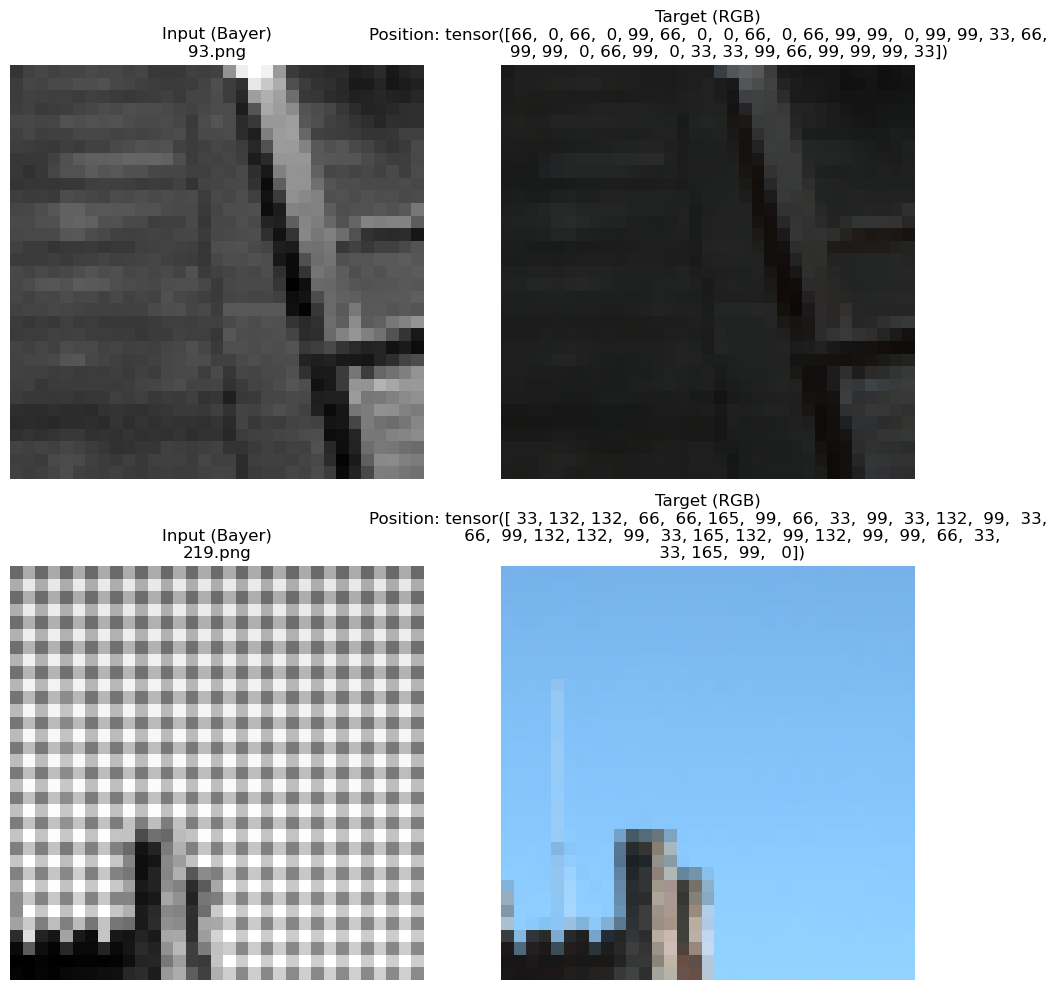


Visualizing val batch:
Batch shapes:
Input: torch.Size([32, 1, 33, 33])
Target: torch.Size([32, 3, 33, 33])


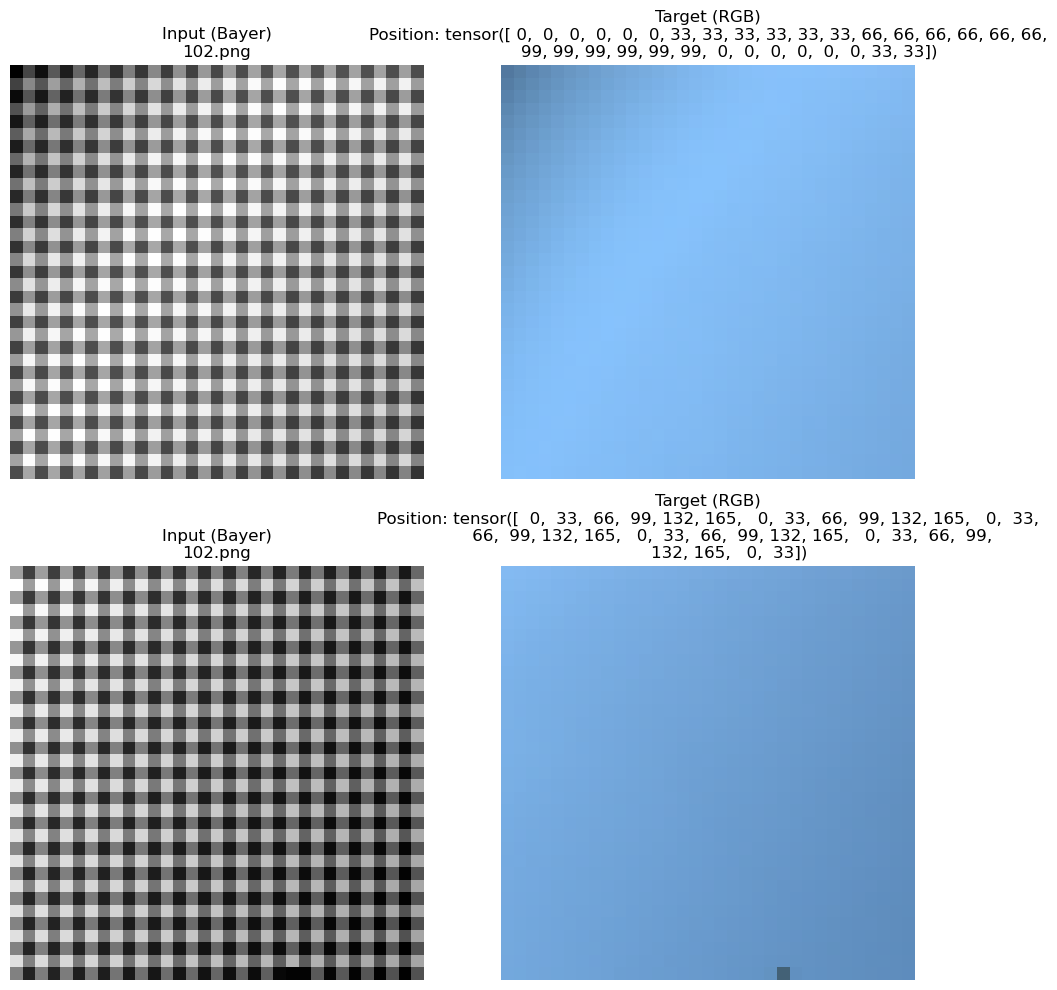


Visualizing test batch:
Batch shapes:
Input: torch.Size([32, 1, 33, 33])
Target: torch.Size([32, 3, 33, 33])


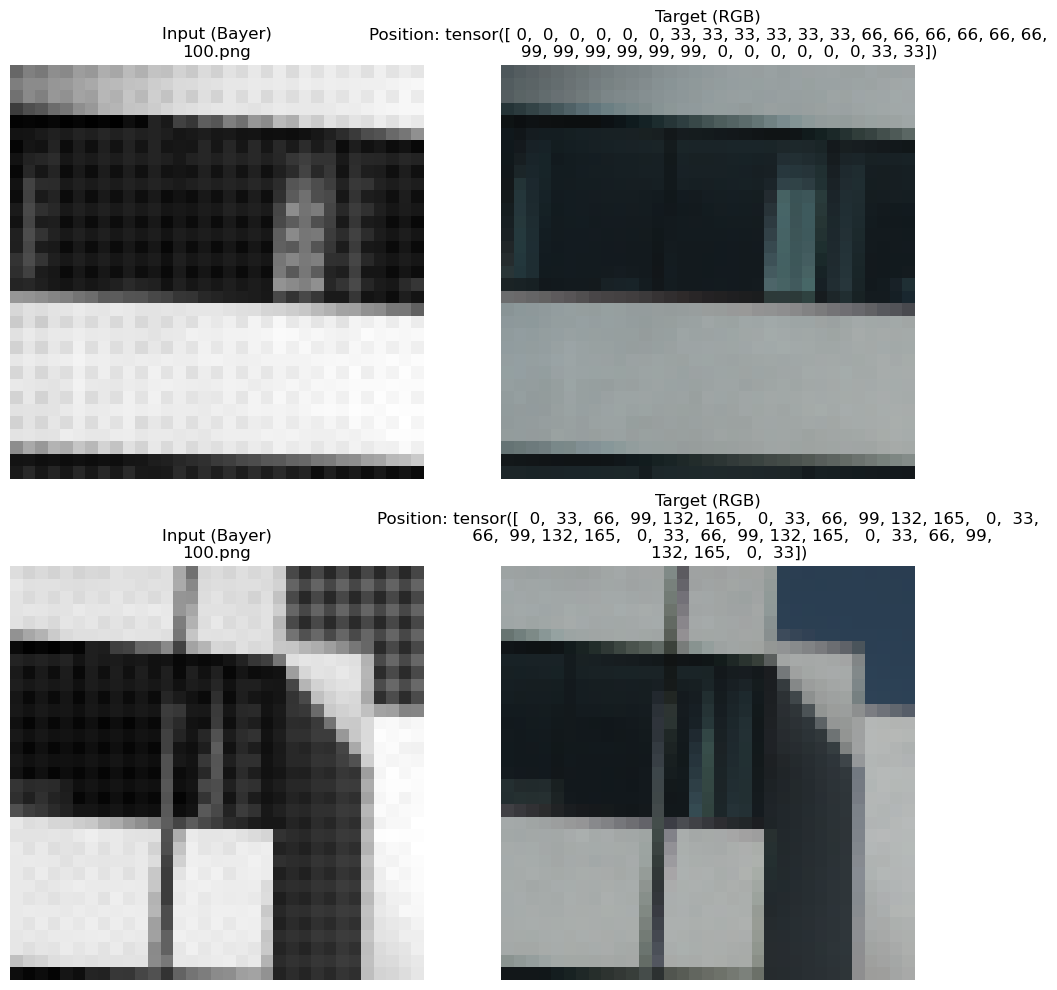

In [21]:
# Training setup
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(
    params=[
        {"params": model.feature_layer.parameters(), "lr": 1},
        {"params": model.mapping_layer.parameters(), "lr": 1},
        {"params": model.reconstruction_layer.parameters(), "lr": 0.1}
    ]
)

# Training parameters
n_epochs = 500
best_val_loss = float('inf')
train_losses = []
val_losses = []

# Training loop
for epoch in tqdm(range(n_epochs), desc='Epochs'):
    # Train
    train_loss = train_epoch(model, data['train_loader'], criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, data['val_loader'], criterion, device)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, 'best_dmcnn_model.pth')
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'\nEpoch [{epoch+1}/{n_epochs}]')
        print(f'Train Loss: {train_loss:.6f}')
        print(f'Val Loss: {val_loss:.6f}')

# Plot training results
plot_results(train_losses, val_losses)

In [ ]:
def visualize_results(model, test_loader, device, num_samples=4):
    """Visualize model predictions"""
    model.eval()
    
    batch = next(iter(test_loader))
    inputs = batch['input'].to(device)
    targets = batch['target']
    
    with torch.no_grad():
        outputs = model(inputs)
    
    num_samples = min(num_samples, len(inputs))
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Input
        axes[i, 0].imshow(inputs[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 0].set_title('Input (Bayer)')
        axes[i, 0].axis('off')
        
        # Target
        axes[i, 1].imshow(targets[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 1].set_title('Target (RGB)')
        axes[i, 1].axis('off')
        
        # Prediction
        axes[i, 2].imshow(outputs[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load best model and visualize results
checkpoint = torch.load('best_dmcnn_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']} with validation loss {checkpoint['val_loss']:.6f}")

visualize_results(model, data['test_loader'], device)